# Preparing Event Flows


In [1]:
# installing necessary libraries

#!pip install gensim==3.8.3
#!pip install scikits.bootstrap
#!pip install ruptures
#!pip install newlinejson

In [17]:
import pickle
import gensim
import numpy as np
from scipy import stats
import pandas as pd
import random

import scipy as sp
import scikits.bootstrap as bootstrap

import newlinejson

import glob
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager

import datetime

from helper import fix_event_name, change_sundays


# Settings

In [29]:
# set paths
model_path = '../models/'
figures_path = './figures/'
output_path = './output/'

for path in [model_path, figures_path, output_path]:
    if not os.path.exists(path):
        os.mkdirs(path)

In [6]:
## Stylesheet graphs

mpl.rcParams.update({"text.usetex": False,
                    "font.family": "Times New Roman",
                    "font.serif": "serif",
                    # "font.size": 14,
                    "mathtext.fontset": "cm",
                    "axes.unicode_minus": False,
                    "axes.labelsize": 12,
                    "xtick.labelsize": 10,
                    "ytick.labelsize": 10,
                    "legend.fontsize": 10,
                    "axes.linewidth": 1
                    })

In [7]:
model_path

'../models/'

# Functions

In [55]:
def load_model(model, model_path):
    print("[INFO] reading model...")
    model_ = model_path + '{}_100_model.pcl'.format(model)
    with open(model_, "rb") as fobj:
        mdl = pickle.load(fobj)
    theta = mdl["theta"]
    time = mdl["dates"]
    return theta, time


def make_event_flow(model, model_path, events, window, rolling, normalize=True):
    print('loading jumps')
    jumps = pd.read_pickle(os.path.join(model_path, 'jumps/{}_100_model_jump.pkl'.format(model)))
    jumps.drop(0, axis=1, inplace=True) #remove point without jumps
    height = int(np.ceil(len(events) / 4))
    fig, axs = plt.subplots(height,4, figsize=(20, 10), facecolor='w', edgecolor='k', sharey=True)
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()
    count = 0
    for key, value in events.items():
        jump_event = jumps[jumps['dates'] == value].drop('dates', axis=1).melt(var_name = 'jump_size', value_name = 'entropy')
        jump_event = jump_event[1500-window:1500+window]
        key = fix_event_name(key)
        if normalize:
            jump_event = jump_event.subtract(jump_event.mean())
        
        axs[count].plot(jump_event['jump_size'], jump_event['entropy'], label=key, linewidth=2.5)
        axs[count].plot(jump_event['jump_size'], jump_event['entropy'].rolling(rolling).mean().shift(int(np.floor(-.5 * rolling))), label=key, linewidth=2.5)
        axs[count].set_title(key +' : ' +value, fontsize=20)

        count += 1
    fig.tight_layout()


    axs[0].set_ylabel('Jump Entropy', fontsize=14)
    axs[4].set_ylabel('Jump Entropy', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_path, '{}_event_flow.png'.format(model)), bbox_inches='tight', transparent=True, dpi=300)


def inspect_one_event(model, event, window, normalize=True):
    fig, axes = plt.subplots(1,2, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    
    jump_event = load_jump_event(model, event, window)
    
    if normalize:
        jump_event = jump_event.subtract(jump_event.mean())

    
    sns.scatterplot(jump_event['jump_size'], jump_event['entropy'], color='g', ax=axes[0])
    positive_ = jump_event[jump_event['jump_size'] > 0]['entropy']
    negative_ = jump_event[jump_event['jump_size'] < 0]['entropy']
    all_ = jump_event['entropy']
    
    plt.title(event)
    print(stats.ks_2samp(positive_, negative_))
    print('Kurtosis positive: {}'.format(kurtosis(positive_)))
    print('Skewness positive: {}'.format(skew(positive_)))
    print('Kurtosis negative: {}'.format(kurtosis(negative_)))
    print('Skewness negative: {}'.format(skew(negative_)))
    #print('skewness all: {}'.format(skew(all_)))
    print('kurtosis all: {}'.format(kurtosis(all_)))

    sns.distplot(positive_, kde=True, bins=25, label='positive', rug=True, color='r', ax=axes[1])
    sns.distplot(negative_, kde=True, bins=25, label='negative', rug=True, color='b', ax=axes[1])
    sns.distplot(all_, kde=True, bins=25, label='all', rug=True, color='black', ax=axes[1])
    plt.title(event)
    plt.legend()
    
    
def load_jump_event(model, event, window):
    jumps = pd.read_pickle('../models/jumps/{}_100_model_jump.pkl'.format(model))
    jumps.drop(0, axis=1, inplace=True) #remove point without jumps
    
    jump_event = jumps[jumps['dates'] == event].drop('dates', axis=1).melt(var_name = 'jump_size', value_name = 'entropy')
    jump_event = jump_event[1500-window:1500+window]
    return jump_event  


def check_model(model, model_path):
    theta, time = load_model(model, model_path)
    entropy_df = daily_entropy(theta, time)
    print('First date: {}'.format(entropy_df.iloc[0]['ds']))
    print('Laste date: {}'.format(entropy_df.iloc[-1]['ds']))
    make_entropy_plot(entropy_df, model)
    monthly_entropy(entropy_df, model)
    
    
def daily_entropy(theta, time):
    entropies = np.zeros(theta.shape[0])
    for i in range(1, theta.shape[0]):
        entropies[i] = jsd(theta[i], theta[i-1])
    return pd.DataFrame(list(zip(time, entropies)),
                          columns=['ds','y'])

def make_entropy_plot(df, model):
    y = df['y'].rolling(30).mean()
    plt.figure(figsize=(20,10))
    plt.plot(df['ds'], df['y'], label='Entropy')
    plt.plot(df['ds'], y, label='rolling mean w=30')
    plt.ylabel('Entropy')
    plt.xlabel('Dates')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    #plt.title('Relative entropy between days')
    plt.savefig(f'figures/{model}_entropy_plot.png')
    plt.close()
    
def monthly_entropy(df, model):
    df['month'] = df['ds'].dt.month
    error_month = df.groupby('month')['y'].apply(lambda x:bootstrap.ci(data=x, statfunction=sp.mean))

    upper_x = [x[1] for x in error_month]
    lower_x = [x[0] for x in error_month]
    mean_x = df.groupby('month')['y'].mean()
    
    plt.plot(mean_x)
    plt.title('Average entropy between days per month')
    plt.errorbar(mean_x.index, mean_x, yerr=[upper_x - mean_x, mean_x - lower_x], linestyle='')
    plt.ylabel('Entropy')
    plt.xlabel('Dates')
    plt.tight_layout()
    plt.show()
    #plt.title('Relative entropy between days')
    plt.savefig(f'figures/{model}_monthly_entropy.png')
    plt.close()
    

def make_event_flow_matrix(jump_path, output_path, window, events):
    event_flow_matrix = []
    for jump_model in glob.glob(jump_path):
        d = {}
        jumps = pd.read_pickle(jump_model)
        newspaper_name = filename = os.path.basename(jump_model).split('_')[0]
        d["newspaper"] = newspaper_name
        d["window_size"] = window
        jumps.drop(0, axis=1, inplace=True) #remove point without jumps
        
        for key, value in events.items():
            jump_event = jumps[jumps['dates'] == value].drop('dates', axis=1).melt(var_name = 'jump_size', value_name = 'entropy')
            jump_event = jumps[jumps['dates'] == value].drop('dates', axis=1).melt(var_name = 'jump_size', value_name = 'entropy')  
            jump_event = jump_event[1500-window:1500+window]
            d[key] = list(jump_event['entropy'].values)
        
        event_flow_matrix.append(d)

    with open(os.path.join(output_path, f'event_flow_{str(window)}.json'), "w") as f:
        newlinejson.dump(event_flow_matrix, f)
    
def make_random_event_flow_matrix(jump_path, output_path, window, n_events):
    '''
    Function to make matrix of a random selection of random events
    Jump_path: directory with jump entropies
    Window: window size to select within jump entropies
    N_events: number of events to select randomly
    '''
    
    event_flow_matrix = []
    
    jumps = pd.read_pickle('../models/jumps/vk_100_model_jump.pkl') # we load the VK file to get a list of dates
    jumps = jumps[jumps['dates'] >= '1950']
    random_dates = random.sample(jumps['dates'].astype(str).tolist(), n_events)
    
    for jump_model in glob.glob(jump_path):
        d = {}
        jumps = pd.read_pickle(jump_model)
        newspaper_name = filename = os.path.basename(jump_model).split('_')[0]
        d["newspaper"] = newspaper_name
        if newspaper_name == 'all':
            pass
        else:           
            d["window_size"] = window
            jumps.drop(0, axis=1, inplace=True) #remove point without jumps

            for date in random_dates:
                jump_event = jumps[jumps['dates'] == date].drop('dates', axis=1).melt(var_name = 'jump_size', value_name = 'entropy')
                jump_event = jump_event[1500-window:1500+window]
                d[date] = list(jump_event['entropy'].values)

            event_flow_matrix.append(d)
    
    
    with open(os.path.join(output_path, f'random_event_flow_{str(window)}.json'), "w") as f:
        newlinejson.dump(event_flow_matrix, f)    
    
#     jumps = pd.read_pickle('../models/jumps/{}_100_model_jump.pkl'.format(model))
#     jumps.drop(0, axis=1, inplace=True) #remove point without jumps
    

## Construct Event Flow Matrix of Random Events


In [57]:
make_random_event_flow_matrix('../models/jumps/**', output_path, 30, 1000)

# check models
Here we check what periods we can use for each model. Long gaps need to be avoided.

[INFO] reading model...
First date: 1919-10-02 00:00:00
Laste date: 1995-12-30 00:00:00


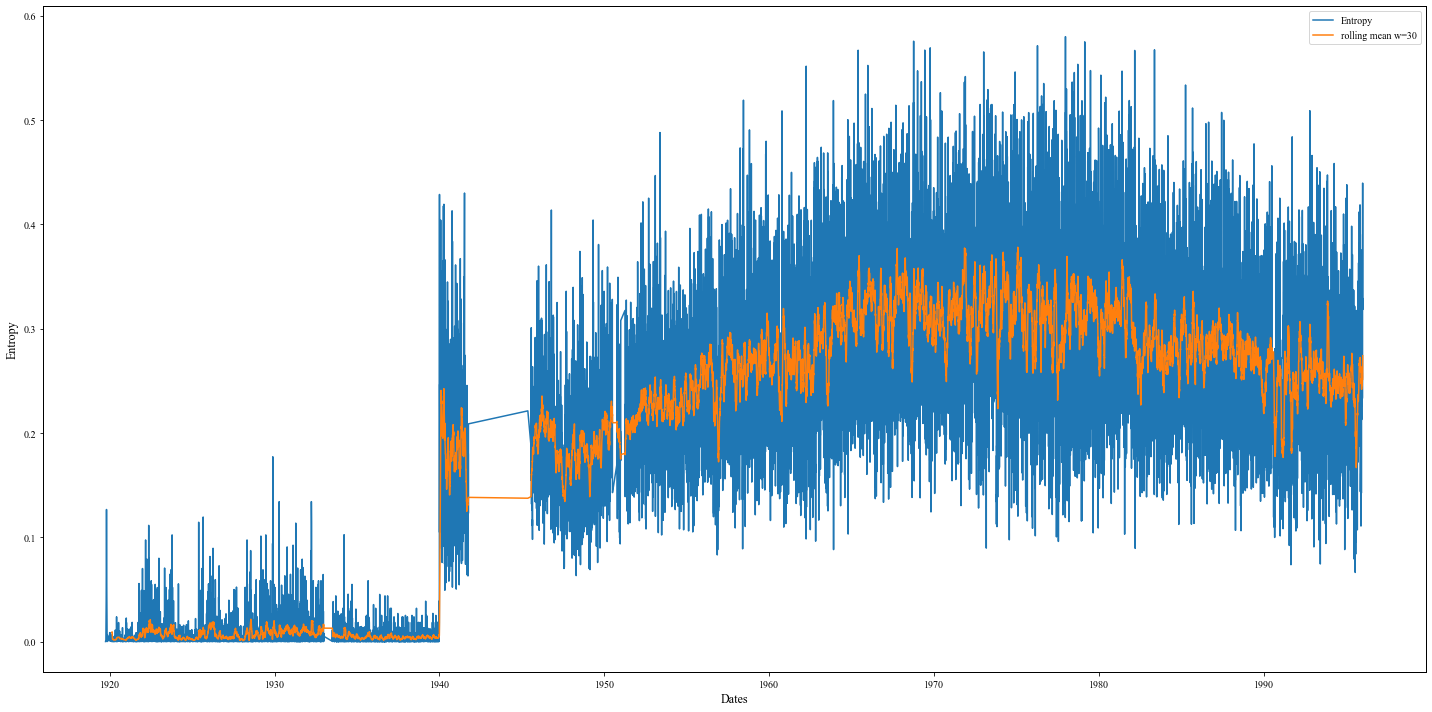

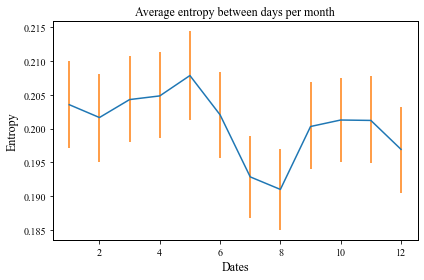

In [18]:
check_model('vk', model_path)

_Volkskrant_ only include from 1949 to 1995 \
_AH_ from 1890 to 1970, with drops around first world war. \
_De Tijd_ from 1890 until 1974-08-31 \
_Telegraaf_ 1893-01-01 to 1994-12-31, gaps around first world war and second world war

# Jump Entropy

## Load Events
Here we prepare our lists of events. The raw list can be found in ``data/raw_events.pickle``

In [20]:
with open('../data/raw_events.pickle', 'rb') as f:
    events = pickle.load(f) 

for k, v in events.items():
    # here we change events that took place on Sundays to Saturdays
    events[k] = changeSundays(v)
    
# the date for the Moon Landing needs manual changing
events['moon_landing'] = '1969-07-21'

In [21]:
# this is a subset of all the events that will be used in the paper
selected_events  = [
'Eisenhower_president', 'Flood_NL', 'Suez_crisis', 'Earthquake_Chili', 'Coup_Ethiopia',
'Kennedy_inauguration', 'StartBerlin_Wall', 'Eichmann_execution', 'End_Cuba_Crisis',
'Coldest_winter', 'Pope_dies', 'Coup_Vietnam', 'riot_congo', 'Auschwitz_trial',
'Biafra', 'Tet_offensive', 'MLK_death', 'Nixon_candidate', 'Retreat_vietnam',
'biafra_end', 'bloody_sunday', 'olympic_munchen', 'yom_kippour', 'oil_crisis',
'palestinian_hostage', 'train_hostage', 'elfsteden', 'crash_747_tenerife',
'raf_death', 'wc_argentina', 'pope_dies', 'jones_town', 'snow_storms_nl',
'sjah_iran', 'harrisburg', 'salt2', 'hostage_iran', 'election_irak', 'ETA', 
'Irak_iran_war', 'Reagan', 'reagan_inauguration', 'coup_surinam',
'protest_nuclear', 'protest_train', 'israel_bombs', 'van_agt_dissolve',
'nuclear_protest_vs', 'financial_crisis_latin_america', 'heineken',
'gulf_war_intensifies', 'iran_offensive', 'schengen', 'challenger', 
'chernobyl', 'end_afghan_occupation_su', 'EC_nl', 'intifada', 'lockerbie', 'moon_landing',
]

In [24]:
events = {your_key: events[your_key] for your_key in selected_events}
events = dict(sorted(events.items(), key=lambda item: item[1]))
print('We have selected {} events'.format(len(events)))

We have selected 60 events


In [25]:
# store cleaned event list
with open(os.path.join(output_path, 'clean_events.pickle'), 'wb') as f:
    pickle.dump(events, f)

In [ ]:
# construct TeX Appendix A based on Event List

In [ ]:
event_clean = {}
for k, v in events.items():
    k = fix_event_name(k)
    event_clean[k] = v

In [ ]:
df = pd.DataFrame.from_dict(event_clean, orient='index').reset_index()
df = pd.concat([df[:30].reset_index(), df[30:].reset_index()], axis=1)
df.drop(['level_0'], axis=1, inplace=True)
df.columns = [['event', 'date', 'event', 'date']]

with open(os.path.join(output_path, 'appendix_a.tex'),'w') as tf:
    tf.write(df.to_latex(index=False))

### Make Event Flow Matrix using clean events

In [28]:
make_event_flow_matrix('../models/jumps/*.pkl', output_path, 90, events)

## Make Event Flow Example

In [26]:
show_cases = ['Suez_crisis',
              'Earthquake_Chili',
              'Biafra',
              'oil_crisis',
              'EC_nl',
              'moon_landing',
              'Retreat_vietnam',
              'wc_argentina'
]

show_case_events = {your_key: events[your_key] for your_key in show_cases } 

loading jumps
Suez crisis
Earthquake Chili
Biafra
oil crisis
EC nl
moon landing
Retreat vietnam
wc argentina


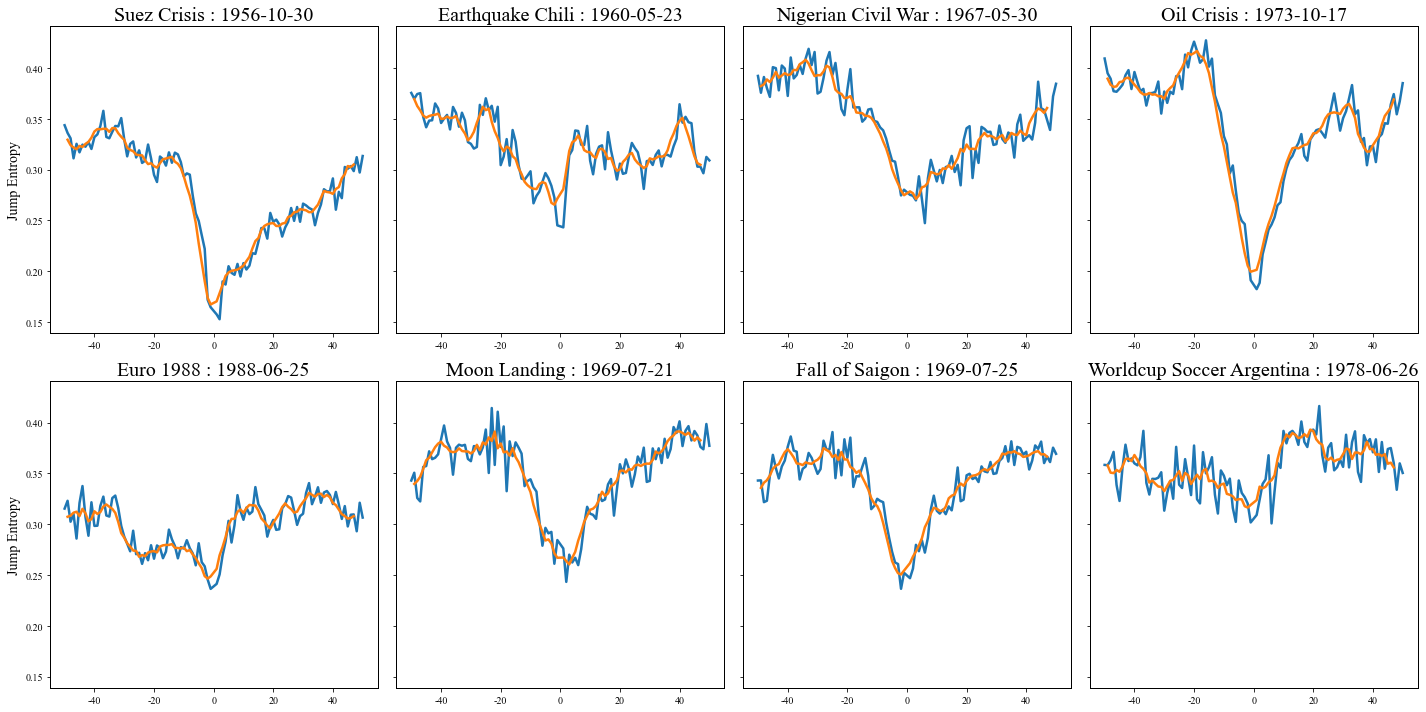

In [43]:
make_event_flow('vk', model_path, show_case_events, 50, 5, normalize=False)